In [1]:
import pdb

import numpy as np
from numpy.random import rand, choice

import torch
import torch.nn as nn
from torch.nn import Linear, ReLU

import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import Sequential, GCNConv, SAGEConv
from torch_geometric.utils import to_dense_adj, to_networkx
from torch_geometric.utils.random import erdos_renyi_graph

import networkx as nx
import gym
from gym.spaces import MultiDiscrete

from collections import namedtuple
from copy import copy, deepcopy
from typing import Optional
from enum import Enum, IntEnum

from env.sys_admin import *

from utils.path_collector import MdpPathCollector
from utils.std_policies import *
from utils.pyg_rollout_functions import rollout
from utils.replay_buffer import anyReplayBuffer

/home/victorialena/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1
n_nodes, n_jobs = 6, 60
n_epoch = 10
n_iter = 20
learning_rate = 5E-3
replay_buffer_size = 10000
gamma = 0.95
batch_size = 128
n_samples = 250
max_path_len = 100
layer_sz = 32

torch.random.manual_seed(seed)
np.random.seed(seed)

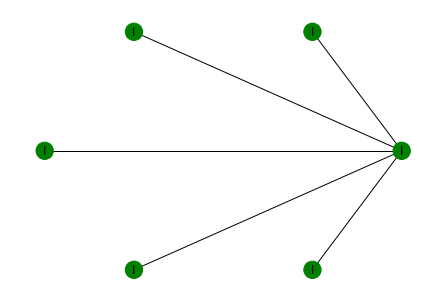

In [3]:
env = sysAdminProbe(nnodes=n_nodes, njobs=n_jobs)
x = env.reset(topology='star')
env.render()

```python
a = env.aspace.sample()
data, r, _, _ = env.step(a)
```

In [4]:
in_channels, out_channels = len(status)+len(load), len(action)

In [5]:
device = 'cpu' #torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [6]:
class sysAdminModel(nn.Module):
    
    def __init__(self, c_in, c_out, c_hidden=16, **kwargs):
        
        super().__init__()
        
        self.model = Sequential('x, edge_index', [
            (SAGEConv(c_in, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            Linear(c_hidden, c_out),
        ])

        self._device = kwargs['device'] if 'device' in kwargs.keys() else 'cpu'

    def forward(self, x, edge_index):
        return self.model(x.to(self._device), edge_index.to(self._device))
    
    def to(self, device):
        super().to(device)
        self._device = device

In [7]:
qf = sysAdminModel(in_channels, out_channels, layer_sz)
target_qf = sysAdminModel(in_channels, out_channels, layer_sz)

In [8]:
qf_criterion = nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf, preprocessing=format_data)
expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=0.1, preprocessing=format_data)

```python
expl_policy = sysRolloutPolicy(env.aspace)
path_collector = MdpPathCollector(env, eval_policy)
paths = path_collector.collect_new_paths(10, 40, False)

for s, a, r, t in zip(paths[0]['observations'], paths[0]['actions'], 
                      paths[0]['rewards'], paths[0]['terminals']):
    print(s.x)
    print(a)
    print(r)
    print(t)
```

```python
example_policy = doNothingPolicy(action.noop)
path_collector = MdpPathCollector(env, example_policy, rollout)
paths = path_collector.collect_new_paths(100, 40, False)
expected_default = np.mean([np.mean(p['rewards']) for p in paths])
print("Expected reward:", expected_default)
```

```python
example_policy = sysRolloutPolicy(env.aspace, 0.)
path_collector = MdpPathCollector(env, example_policy, rollout)
paths = path_collector.collect_new_paths(100, 40, False)
expected_heuristic = np.mean([np.mean(p['rewards']) for p in paths])
print("Expected reward:", expected_heuristic)
print_path(paths[1])
```

In [ ]:
expl_path_collector = MdpPathCollector(env, expl_policy, rollout)
eval_path_collector = MdpPathCollector(env, eval_policy, rollout)
replay_buffer = anyReplayBuffer(replay_buffer_size)
optimizer = Adam(qf.parameters(), lr=learning_rate)

#### Reinforcement Learning

In [ ]:
loss = []
avg_r_train = []
avg_r_test = []

for i in range(n_epoch):
    qf.train(False)
    paths = eval_path_collector.collect_new_paths(n_samples//4, max_path_len, False)
    avg_r_test.append(np.mean([np.mean(p['rewards']) for p in paths]))
    
    paths = expl_path_collector.collect_new_paths(n_samples, max_path_len, False)
    replay_buffer.add_paths(paths)
    
    qf.train(True)    
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)
        _, counts = batch.batch.unique(return_counts=True)
        rewards = batch.r.repeat_interleave(counts)
        terminals = batch.t.repeat_interleave(counts).to(torch.float)
        actions = batch.a

        obs = batch.x
        next_obs = batch.next_s
        
        out = target_qf(format_input(batch.next_s), batch.edge_index)
        
        target_q_values = out.max(-1).values
        y_target = rewards + (1. - terminals) * gamma * target_q_values
        out = qf(format_input(batch.x), batch.edge_index)
                               
        actions_one_hot = F.one_hot(actions.to(torch.int64), num_classes=len(action))
        y_pred = torch.sum(out * actions_one_hot, dim=-1)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r_train.append(rewards.mean().item())
        
        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()
        
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-n_iter:]),
          ", rewards: (train) ", np.mean(avg_r_train[-n_iter:]),
          ", (test) ", avg_r_test[-1])

#### plot

```python
import matplotlib.pyplot as plt

plt.plot(np.arange(n_iter*n_epoch), [expected_default]*(n_iter*n_epoch), label = "do nothing", color='lightgray')
plt.plot(np.arange(n_iter*n_epoch), [expected_heuristic]*(n_iter*n_epoch), label = "reboot when dead",  color='darkgray')

plt.plot(np.arange(n_iter*n_epoch), avg_r_train, label = "avg R (train)")
plt.plot(np.arange(n_iter, n_iter*n_epoch+1, step=n_iter), avg_r_test, label = "avg R (test)")
plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.savefig('training_log.png', dpi=300)
```

```python
# ---------------------- Record Traj

import networkx as nx
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

def simple_update(num, obs, ax, colors=np.array(['green', 'yellow', 'red']), labels=np.array(['I', 'L', 'S'])):
    ax.clear()
    
    s = obs[num]
    g = to_networkx(s, to_undirected=True)
    color_map = colors[s.x.numpy()[:, 0]]
    label_map = labels[s.x.numpy()[:, 1]]    
    nx.draw_circular(g, 
                     node_color=color_map,
                     labels={i: l for i, l in enumerate(label_map)}, 
                     ax=ax)
    
    ax.set_title("Frame {}".format(num))

def simple_animation(obs, name='animation_1'):
    "Record an example trajectory."
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    ani = animation.FuncAnimation(fig, simple_update, frames=len(obs), fargs=(obs, ax))
    ani.save(name+'.gif', writer='imagemagick', savefig_kwargs={'facecolor':'white'}, fps=1)

    plt.show()
    
simple_animation(paths[0]['observations'])
```

### Notes
1. Instead of a GCN use a normal GNN - SAGEGraph
2. add self loops - default on GCNs
3. try over fitting a linear layer - done